# **Bibliotecas**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.7 MB/s eta 0:00:00


In [1]:
import urllib.request
import os
import zipfile
import pandas as pd

import glob
from tqdm.auto import tqdm
tqdm.pandas()
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

import numpy as np
from skimage.transform import resize

import optuna

# **Base de dados (placas de trânsito)**

In [2]:
# URL para o conjunto de dados
url = ("https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip")

# Verifica se o arquivo já existe para evitar baixar novamente
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    # Define o nome do arquivo
    filename = "./GTSRB_Final_Training_Images.zip"
    # Baixa o arquivo da URL e salva com o nome definido
    urllib.request.urlretrieve(url, filename)

#Extraindo arquivos

# Caminho do arquivo zip
zip_path = 'GTSRB_Final_Training_Images.zip'

# Pasta onde os arquivos serão extraídos
extract_to = 'GTSRB_Final_Training_Images/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Arquivos extraídos para: {extract_to}")

Arquivos extraídos para: GTSRB_Final_Training_Images/


In [3]:
# Lista para armazenar os caminhos completos de todos os arquivos CSV encontrados
csv_files = []

# Percorrer a pasta principal e suas subpastas
for root, dirs, files in os.walk(extract_to):
    # Filtrar apenas os arquivos .csv em cada pasta
    for file in files:
        if file.endswith('.csv'):
            # Adicionar o caminho completo do arquivo à lista
            csv_files.append(os.path.join(root, file))

dfs = []

# Ler cada arquivo CSV e adicionar a um dataframe na lista
for arquivo in csv_files:
    df = pd.read_csv(arquivo, sep=";")  # ajuste o sep se necessário
    df['Path'] = '/'.join(arquivo.split('/')[:-1]) + '/' + df.Filename
    dfs.append(df)

# Concatenar todos os dataframes em um único dataframe final
df_final = pd.concat(dfs, ignore_index=True)

# Imprimir o formato do dataframe final e as primeiras linhas
print(df_final.shape)
df_final.head()

(39209, 9)


Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0  00000_00000.ppm     26      27       6       6      21      21       36   
1  00000_00001.ppm     29      27       6       5      23      22       36   
2  00000_00002.ppm     28      29       5       6      23      24       36   
3  00000_00003.ppm     31      31       5       6      25      26       36   
4  00000_00004.ppm     33      33       5       5      27      28       36   

                                                Path  
0  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
1  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
2  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
3  GTSRB_Final_Training_Images/GTSRB/Final_Traini...  
4  GTSRB_Final_Training_Images/GTSRB/Final_Traini...

In [4]:
classes = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}



In [5]:
df_final['ClassName'] = df_final['ClassId'].map(classes)

In [6]:
img_size = 32
def load_img(img_file):
  try:
    img = Image.open('./'+img_file).convert('RGB')
    img = np.array(img, dtype=np.uint8)

    img = resize(
        img,
        output_shape=(img_size, img_size, 3),
        mode='reflect',
        anti_aliasing=True,
        preserve_range=False  # -> output in [0,1]
    )

    img = (img * 255).astype(np.uint8)
    return img
  except:
    return None


In [7]:
df_final['Image'] = df_final.progress_apply(lambda x: load_img(x['Path']), axis=1)

df_final = df_final.dropna(subset=['Image']).reset_index(drop=True)

  0%|          | 0/39209 [00:00<?, ?it/s]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_final.Image,
                                                    df_final.ClassName,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=df_final.ClassName
                                                    )

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Converte os dados para tensores PyTorch e normaliza para o intervalo [-1, 1]
tensor_x_treino = torch.from_numpy(np.array(list(X_train), dtype=np.uint8)).permute(0, 3, 1, 2).to(torch.float32) / 255.0
tensor_x_teste  = torch.from_numpy(np.array(list(X_test), dtype=np.uint8)).permute(0, 3, 1, 2).to(torch.float32) / 255.0

# Normalização para o intervalo [-1, 1]
tensor_x_treino = (tensor_x_treino - 0.5) / 0.5
tensor_x_teste  = (tensor_x_teste  - 0.5) / 0.5

# Converte os rótulos para tensores PyTorch (tipo long para classificação)
# Mapear os nomes das classes para IDs numéricos
class_to_id = {name: id for id, name in classes.items()}
tensor_y_treino = torch.from_numpy(np.array([class_to_id[label] for label in y_train])).to(torch.long)
tensor_y_teste = torch.from_numpy(np.array([class_to_id[label] for label in y_test])).to(torch.long)


# Cria os TensorDatasets
dataset_treino = TensorDataset(tensor_x_treino, tensor_y_treino)
dataset_teste = TensorDataset(tensor_x_teste, tensor_y_teste)

print("TensorDatasets criados com sucesso!")

TensorDatasets criados com sucesso!


torch.float32


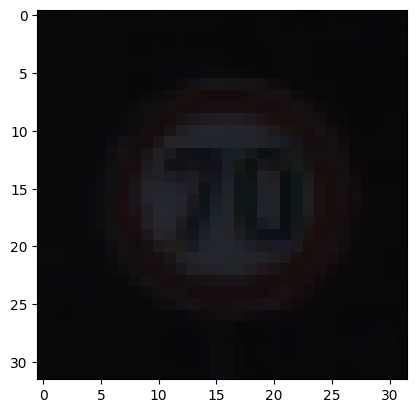

In [10]:
import matplotlib.pyplot as plt

image, label = dataset_treino[0] # Usar dataset_treino para pegar um exemplo

# Denormalize the image data from [-1, 1] to [0, 1] for plotting
image_denormalized = (image * 0.5) + 0.5

plt.imshow(image_denormalized.permute(1, 2, 0)) # Ajusta a ordem dos canais para (altura, largura, canais) para matplotlib
print(image.dtype)

# **Modelo**

In [11]:
# ===== Célula 1: Imports, configs e utilitários =====
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

# Reprodutibilidade
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)

# Dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# Saídas
OUT_DIR = "./resultados_mlp_optuna"
os.makedirs(OUT_DIR, exist_ok=True)
METRICS_CSV = os.path.join(OUT_DIR, "todas_metricas_por_epoca.csv")
TRIALS_CSV  = os.path.join(OUT_DIR, "resumo_trials.csv")
BEST_MODEL  = os.path.join(OUT_DIR, "best_model_state_dict.pt")

# Número de classes e dimensão de entrada (imagens 3x32x32 do seu pipeline)
N_CLASSES = 43          # len(classes)
INPUT_DIM = 3 * img_size * img_size # Flatten (C*H*W)

DEVICE: cuda


In [12]:
# ===== Célula 2: Criação do conjunto de validação =====
# Parte do pressuposto de que você já tem: dataset_treino e dataset_teste (TensorDataset)
# e DataLoaders trainloader / testloader criados nas células anteriores do seu notebook.

# Vamos criar train/val a partir do dataset_treino (80/20):
val_ratio = 0.2

# Cria um TensorDataset com dados de treino e rótulos
full_train_dataset = TensorDataset(tensor_x_treino, tensor_y_treino)

n_total = len(full_train_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# Divide o dataset completo de treino em treino e validação
train_ds, val_ds = random_split(full_train_dataset, [n_train, n_val],
                                generator=torch.Generator().manual_seed(RANDOM_SEED))

# DataLoaders (mantendo batch e workers semelhantes aos seus)
BATCH_SIZE_DEFAULT = 64

pin = torch.cuda.is_available()

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE_DEFAULT, shuffle=True,
    num_workers=0, pin_memory=pin, persistent_workers=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE_DEFAULT, shuffle=False,
    num_workers=0, pin_memory=pin, persistent_workers=False
)
test_loader = DataLoader(
    dataset_teste, batch_size=BATCH_SIZE_DEFAULT, shuffle=False,
    num_workers=0, pin_memory=pin, persistent_workers=False
)

len(train_ds), len(val_ds), len(dataset_teste)

len(train_ds), len(val_ds), len(dataset_teste)

(21957, 5489, 11763)

In [13]:
# ===== Célula 3: Construtor do MLP (nn.Sequential) =====
def build_mlp_sequential(input_dim:int,
                         hidden_sizes:list,
                         output_dim:int,
                         activation:str="relu",
                         dropout_p:float=0.0) -> nn.Sequential:
    """
    Cria um MLP via nn.Sequential:
    - Começa com nn.Flatten() para achatar (N, C, H, W) -> (N, C*H*W)
    - hidden_sizes: lista com nº de neurônios por camada oculta (ex.: [256,128])
    - activation: 'relu' ou 'sigmoid'
    - dropout_p: 0.0..0.5
    - output_dim: número de classes (43)
    """
    acts = {"relu": nn.ReLU, "sigmoid": nn.Sigmoid}
    layers = [nn.Flatten()]
    prev = input_dim
    for h in hidden_sizes:
        layers += [nn.Linear(prev, h), acts[activation]()]
        if dropout_p > 0:
            layers.append(nn.Dropout(dropout_p))
        prev = h
    layers.append(nn.Linear(prev, output_dim))
    return nn.Sequential(*layers).to(DEVICE)

In [14]:
# ===== Célula 4: Funções de treino/val/test =====
def train_one_epoch(model, loader, optimizer, criterion):
    """
    Treina 1 época:
    - Retorna (loss_médio, acc)
    """
    model.train()
    losses, preds_all, y_all = [], [], []
    pbar = tqdm(loader, desc="Treinando", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        preds = torch.argmax(logits, 1)
        preds_all.append(preds.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())
        pbar.set_postfix(loss=np.mean(losses))

    preds_all = np.concatenate(preds_all); y_all = np.concatenate(y_all)
    acc = accuracy_score(y_all, preds_all)
    return float(np.mean(losses)), float(acc)


@torch.no_grad()
def evaluate(model, loader, criterion):
    """
    Avaliação:
    - Retorna (loss_médio, acc)
    """
    model.eval()
    losses, preds_all, y_all = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        losses.append(loss.item())
        preds = torch.argmax(logits, 1)
        preds_all.append(preds.detach().cpu().numpy())
        y_all.append(yb.detach().cpu().numpy())

    preds_all = np.concatenate(preds_all); y_all = np.concatenate(y_all)
    acc = accuracy_score(y_all, preds_all)
    return float(np.mean(losses)), float(acc)

In [15]:
# ===== Célula 5: Execução de um treino completo com logging =====
def run_training(params:dict,
                 train_loader, val_loader, test_loader,
                 input_dim:int, n_classes:int,
                 n_epochs:int, # Added n_epochs as a parameter
                 trial_id=None):
    """
    Executa treino completo conforme 'params' e registra histórico por época.
    params esperados:
      - hidden_sizes: list[int]
      - activation: 'relu'|'sigmoid'
      - dropout_p: float [0, 0.5]
      - lr: float
      - batch_size: int (não usado aqui pois DataLoader já está criado)
    """
    lr       = params.get("lr", 1e-3)
    # n_epochs = params.get("n_epochs", 12) # Removed n_epochs from params
    hidden   = params["hidden_sizes"]
    act      = params["activation"]
    drop     = params["dropout_p"]

    model = build_mlp_sequential(input_dim, hidden, n_classes, activation=act, dropout_p=drop)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    best_val_acc, best_state = -1.0, None

    for epoch in tqdm(range(1, n_epochs+1), desc=f"Trial {trial_id} | Épocas", leave=False):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc = evaluate(model, val_loader, criterion)

        history.append({
            "trial_id": trial_id,
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "val_loss": va_loss,
            "val_acc": va_acc,
            **params,
        })

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Avaliar no teste usando o melhor estado
    if best_state is not None:
        model.load_state_dict(best_state)
    te_loss, te_acc = evaluate(model, test_loader, criterion)

    return {
        "history": history,
        "best_val_acc": best_val_acc,
        "test_loss": te_loss,
        "test_acc": te_acc,
        "best_state": best_state,
    }

In [16]:
def suggest_params_optuna(trial):
    """
    Espaço de busca:
      - nº de camadas: 1..4
      - neurônios: 32..512 (log)
      - ativação: relu|sigmoid
      - dropout: 0.0..0.5
      - lr: 1e-4..3e-2 (log)
      - batch_size: 64|128|256  (não usado aqui, mas salvo no log)
    """
    n_layers = trial.suggest_int("n_hidden_layers", 1, 4)
    hidden = [trial.suggest_int(f"n_units_l{i+1}", 32, 512, log=True) for i in range(n_layers)]
    return {
        "hidden_sizes": hidden,
        "activation": trial.suggest_categorical("activation", ["relu", "sigmoid"]),
        "dropout_p": trial.suggest_float("dropout_p", 0.0, 0.5),
        "lr": trial.suggest_float("lr", 1e-4, 3e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256]),
    }

def random_params_fallback():
    """Fallback simples caso Optuna não esteja disponível."""
    n_layers = random.randint(1, 4)
    hidden = [int(2 ** random.randint(5, 9)) for _ in range(n_layers)]  # 32..512
    return {
        "hidden_sizes": hidden,
        "activation": random.choice(["relu", "sigmoid"]),
        "dropout_p": random.uniform(0.0, 0.5),
        "lr": 10 ** random.uniform(-4, -1.5),
        "batch_size": random.choice([64, 128, 256]),
    }

In [18]:
# ===== Célula 7: Execução da busca, CSVs e melhor modelo =====
def run_hparam_search(n_trials=5, n_epochs=50, output_prefix=""):
    """
    Executa n_trials de busca (Optuna ou fallback), salva CSVs e re-treina o melhor.
    Adiciona um prefixo aos arquivos de saída se especificado.
    Retorna o DataFrame de trials e o DataFrame de histórico do melhor trial,
    além dos melhores parâmetros encontrados.
    """
    all_hist = []
    trials_rows = []
    best_params = None # Initialize best_params

    # Define os caminhos dos arquivos de saída com o prefixo
    metrics_csv_path = os.path.join(OUT_DIR, f"{output_prefix}todas_metricas_por_epoca.csv")
    trials_csv_path  = os.path.join(OUT_DIR, f"{output_prefix}resumo_trials.csv")
    best_model_path  = os.path.join(OUT_DIR, f"{output_prefix}best_model_state_dict.pt")

    if optuna is not None:
        print("Optuna encontrado. Iniciando estudo...")
        def objective(trial):
            params = suggest_params_optuna(trial)
            res = run_training(params, train_loader, val_loader, test_loader,
                               INPUT_DIM, N_CLASSES, n_epochs=n_epochs, trial_id=trial.number)
            all_hist.extend(res["history"])

            # Get metrics from the last epoch for this trial
            last_epoch_metrics = res["history"][-1] if res["history"] else {}

            trials_rows.append({
                "trial_id": trial.number, **params,
                "best_val_acc": res["best_val_acc"],
                "test_acc": res["test_acc"],
                "test_loss": res["test_loss"],
                "train_acc": last_epoch_metrics.get("train_acc"),
                "val_acc": last_epoch_metrics.get("val_acc"),
                "train_loss": last_epoch_metrics.get("train_loss"),
                "val_loss": last_epoch_metrics.get("val_loss"),
            })
            print(f"Trial {trial.number} - Test Acc: {res['test_acc']:.4f}, Test Loss: {res['test_loss']:.4f}")
            return res["best_val_acc"]

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        best_trial = study.best_trial

        # Reconstruir params do melhor trial
        hidden = [best_trial.params[k] for k in sorted(best_trial.params) if k.startswith("n_units_l")]
        best_params = {
            "hidden_sizes": hidden,
            "activation": best_trial.params["activation"],
            "dropout_p": best_trial.params["dropout_p"],
            "lr": best_trial.params["lr"],
            "batch_size": best_trial.params["batch_size"],
            "n_epochs": n_epochs, # Use the fixed n_epochs
        }
        print(f"Melhor trial #{best_trial.number} | best_val_acc={study.best_value:.4f}")
    else:
        print("Optuna NÃO encontrado. Usando fallback aleatório.")
        best_val, best_params = -1.0, None
        for t in tqdm(range(n_trials), desc="Trials (fallback)"):
            params = random_params_fallback()
            res = run_training(params, train_loader, val_loader, test_loader,
                               INPUT_DIM, N_CLASSES, n_epochs=n_epochs, trial_id=t)
            all_hist.extend(res["history"])

            # Get metrics from the last epoch for this trial
            last_epoch_metrics = res["history"][-1] if res["history"] else {}

            trials_rows.append({
                "trial_id": t, **params,
                "best_val_acc": res["best_val_acc"],
                "test_acc": res["test_acc"],
                "test_loss": res["test_loss"],
                "train_acc": last_epoch_metrics.get("train_acc"),
                "val_acc": last_epoch_metrics.get("val_acc"),
                "train_loss": last_epoch_metrics.get("train_loss"),
                "val_loss": last_epoch_metrics.get("val_loss"),
            })
            print(f"Trial {t} - Test Acc: {res['test_acc']:.4f}, Test Loss: {res['test_loss']:.4f}")
            if res["best_val_acc"] > best_val:
                best_val, best_params = res["best_val_acc"], params

    # Salvar CSVs
    pd.DataFrame(all_hist).to_csv(metrics_csv_path, index=False)
    trials_df = pd.DataFrame(trials_rows).sort_values("best_val_acc", ascending=False)

    # Reorder columns
    metric_cols = ["train_acc", "val_acc", "test_acc", "train_loss", "val_loss", "test_loss"]
    other_cols = [col for col in trials_df.columns if col not in metric_cols]
    trials_df = trials_df[other_cols[:6] + metric_cols + other_cols[6:]] # Adjust indices based on your dataframe structure

    trials_df.to_csv(trials_csv_path, index=False)

    # Re-treinar melhor configuração (para salvar e plotar)
    print("Treinando melhor configuração para salvar modelo e curvas...")
    best_run = run_training(best_params, train_loader, val_loader, test_loader,
                            INPUT_DIM, N_CLASSES, n_epochs=n_epochs, trial_id=9999)
    torch.save(best_run["best_state"], best_model_path)
    print(f"Melhor configuração - Test Acc: {best_run['test_acc']:.4f}, Test Loss: {best_run['test_loss']:.4f}")


    return trials_df, pd.DataFrame(best_run["history"]), best_params # Return best_params

# Execute (ajuste n_trials conforme seu tempo)
trials_df, best_hist_df, best_params = run_hparam_search(n_trials=16, n_epochs=40, output_prefix="experimento_01_") # Capture best_params
trials_df.head()

[I 2025-10-16 02:21:48,926] A new study created in memory with name: no-name-c9657fdd-bf66-41f4-bf63-805b9c03e7b9


Optuna encontrado. Iniciando estudo...


  0%|          | 0/16 [00:00<?, ?it/s]

Trial 0 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 0 - Test Acc: 0.9139, Test Loss: 0.3520
[I 2025-10-16 02:22:48,874] Trial 0 finished with value: 0.9163782109673894 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 90, 'n_units_l2': 64, 'activation': 'relu', 'dropout_p': 0.41724537610532475, 'lr': 0.00019691361134982458, 'batch_size': 256}. Best is trial 0 with value: 0.9163782109673894.


Trial 1 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 1 - Test Acc: 0.7927, Test Loss: 0.6545
[I 2025-10-16 02:23:43,206] Trial 1 finished with value: 0.7965020950992895 and parameters: {'n_hidden_layers': 1, 'n_units_l1': 468, 'activation': 'sigmoid', 'dropout_p': 0.35443302185749853, 'lr': 0.00629279133090689, 'batch_size': 64}. Best is trial 0 with value: 0.9163782109673894.


Trial 2 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 2 - Test Acc: 0.9491, Test Loss: 0.2062
[I 2025-10-16 02:24:51,075] Trial 2 finished with value: 0.9495354345053744 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 107, 'n_units_l2': 152, 'n_units_l3': 46, 'activation': 'relu', 'dropout_p': 0.05491616935581761, 'lr': 0.00018896473013868306, 'batch_size': 256}. Best is trial 2 with value: 0.9495354345053744.


Trial 3 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 3 - Test Acc: 0.9160, Test Loss: 0.3318
[I 2025-10-16 02:25:56,117] Trial 3 finished with value: 0.9141920204044452 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 62, 'n_units_l2': 220, 'activation': 'sigmoid', 'dropout_p': 0.3836533732602478, 'lr': 0.001220253923137297, 'batch_size': 64}. Best is trial 2 with value: 0.9495354345053744.


Trial 4 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 4 - Test Acc: 0.9289, Test Loss: 0.3198
[I 2025-10-16 02:26:56,371] Trial 4 finished with value: 0.9309528147203497 and parameters: {'n_hidden_layers': 1, 'n_units_l1': 165, 'activation': 'sigmoid', 'dropout_p': 0.44288072147534224, 'lr': 0.00018469446507221447, 'batch_size': 128}. Best is trial 2 with value: 0.9495354345053744.


Trial 5 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 5 - Test Acc: 0.0566, Test Loss: 3.4865
[I 2025-10-16 02:28:02,038] Trial 5 finished with value: 0.053926033885953725 and parameters: {'n_hidden_layers': 4, 'n_units_l1': 48, 'n_units_l2': 313, 'n_units_l3': 201, 'n_units_l4': 267, 'activation': 'relu', 'dropout_p': 0.365866725916246, 'lr': 0.01233398205321554, 'batch_size': 64}. Best is trial 2 with value: 0.9495354345053744.


Trial 6 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 6 - Test Acc: 0.8512, Test Loss: 1.8058
[I 2025-10-16 02:29:07,596] Trial 6 finished with value: 0.8586263435962834 and parameters: {'n_hidden_layers': 1, 'n_units_l1': 363, 'activation': 'relu', 'dropout_p': 0.05635662461000018, 'lr': 0.0046425984034302835, 'batch_size': 64}. Best is trial 2 with value: 0.9495354345053744.


Trial 7 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 7 - Test Acc: 0.6701, Test Loss: 1.0638
[I 2025-10-16 02:30:15,168] Trial 7 finished with value: 0.6704317726361815 and parameters: {'n_hidden_layers': 4, 'n_units_l1': 59, 'n_units_l2': 65, 'n_units_l3': 128, 'n_units_l4': 44, 'activation': 'relu', 'dropout_p': 0.4575256657302135, 'lr': 0.0006248113886530532, 'batch_size': 64}. Best is trial 2 with value: 0.9495354345053744.


Trial 8 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 8 - Test Acc: 0.5935, Test Loss: 1.2024
[I 2025-10-16 02:31:18,749] Trial 8 finished with value: 0.5951903807615231 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 250, 'n_units_l2': 37, 'n_units_l3': 108, 'activation': 'sigmoid', 'dropout_p': 0.4664935977486544, 'lr': 0.0012013181029367015, 'batch_size': 64}. Best is trial 2 with value: 0.9495354345053744.


Trial 9 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 9 - Test Acc: 0.7885, Test Loss: 0.6662
[I 2025-10-16 02:32:31,203] Trial 9 finished with value: 0.8045181271634178 and parameters: {'n_hidden_layers': 4, 'n_units_l1': 299, 'n_units_l2': 233, 'n_units_l3': 33, 'n_units_l4': 162, 'activation': 'sigmoid', 'dropout_p': 0.20365050493800146, 'lr': 0.002572882163811707, 'batch_size': 64}. Best is trial 2 with value: 0.9495354345053744.


Trial 10 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 10 - Test Acc: 0.9074, Test Loss: 0.3531
[I 2025-10-16 02:33:47,729] Trial 10 finished with value: 0.9098196392785571 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 34, 'n_units_l2': 122, 'n_units_l3': 34, 'activation': 'relu', 'dropout_p': 0.01294564952723852, 'lr': 0.00010048307419162838, 'batch_size': 256}. Best is trial 2 with value: 0.9495354345053744.


Trial 11 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 11 - Test Acc: 0.9458, Test Loss: 0.2275
[I 2025-10-16 02:34:59,471] Trial 11 finished with value: 0.9449808708325742 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 149, 'n_units_l2': 449, 'activation': 'sigmoid', 'dropout_p': 0.15860785256496335, 'lr': 0.00032890530208788427, 'batch_size': 128}. Best is trial 2 with value: 0.9495354345053744.


Trial 12 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 12 - Test Acc: 0.8918, Test Loss: 0.4031
[I 2025-10-16 02:36:14,516] Trial 12 finished with value: 0.8952450355255966 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 142, 'n_units_l2': 494, 'n_units_l3': 70, 'activation': 'sigmoid', 'dropout_p': 0.13653353004220817, 'lr': 0.0003950606159656861, 'batch_size': 128}. Best is trial 2 with value: 0.9495354345053744.


Trial 13 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 13 - Test Acc: 0.9515, Test Loss: 0.1904
[I 2025-10-16 02:37:24,958] Trial 13 finished with value: 0.9546365458189106 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 94, 'n_units_l2': 130, 'activation': 'relu', 'dropout_p': 0.11708404093680749, 'lr': 0.00044466512849283113, 'batch_size': 128}. Best is trial 13 with value: 0.9546365458189106.


Trial 14 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 14 - Test Acc: 0.9448, Test Loss: 0.2083
[I 2025-10-16 02:38:41,998] Trial 14 finished with value: 0.9455274184733102 and parameters: {'n_hidden_layers': 3, 'n_units_l1': 85, 'n_units_l2': 131, 'n_units_l3': 317, 'activation': 'relu', 'dropout_p': 0.0703257545544487, 'lr': 0.0005907322635890149, 'batch_size': 256}. Best is trial 13 with value: 0.9546365458189106.


Trial 15 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Trial 15 - Test Acc: 0.9459, Test Loss: 0.2122
[I 2025-10-16 02:39:50,318] Trial 15 finished with value: 0.9526325378028785 and parameters: {'n_hidden_layers': 2, 'n_units_l1': 105, 'n_units_l2': 124, 'activation': 'relu', 'dropout_p': 0.12001602927308407, 'lr': 0.00015617051361503848, 'batch_size': 128}. Best is trial 13 with value: 0.9546365458189106.
Melhor trial #13 | best_val_acc=0.9546
Treinando melhor configuração para salvar modelo e curvas...


Trial 9999 | Épocas:   0%|          | 0/40 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Treinando:   0%|          | 0/344 [00:00<?, ?it/s]

Melhor configuração - Test Acc: 0.9571, Test Loss: 0.1967


trial_id    hidden_sizes activation  dropout_p        lr  batch_size  \
13        13       [94, 130]       relu   0.117084  0.000445         128   
15        15      [105, 124]       relu   0.120016  0.000156         128   
2          2  [107, 152, 46]       relu   0.054916  0.000189         256   
14        14  [85, 131, 317]       relu   0.070326  0.000591         256   
11        11      [149, 449]    sigmoid   0.158608  0.000329         128   

    train_acc   val_acc  test_acc  train_loss  val_loss  test_loss  \
13   0.935192  0.915285  0.951543    0.209689  0.313688   0.190350   
15   0.943435  0.937694  0.945932    0.194257  0.221954   0.212211   
2    0.944801  0.949535  0.949078    0.183224  0.200529   0.206154   
14   0.939655  0.943888  0.944827    0.186161  0.230570   0.208325   
11   0.926857  0.930224  0.945762    0.249048  0.254593   0.227520   

    best_val_acc  
13      0.954637  
15      0.952633  
2       0.949535  
14      0.945527  
11      0.944981

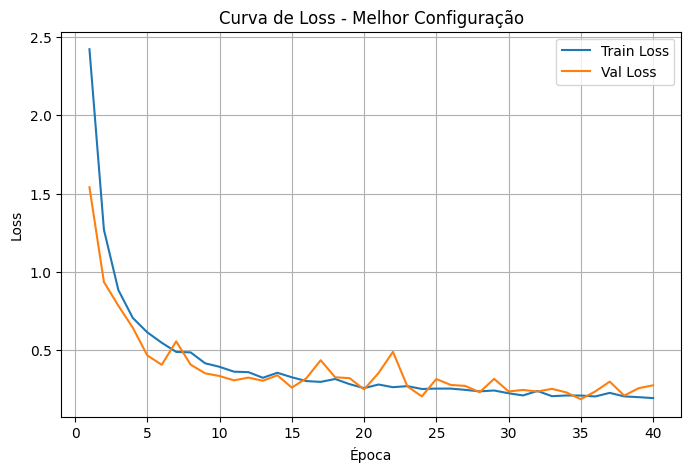

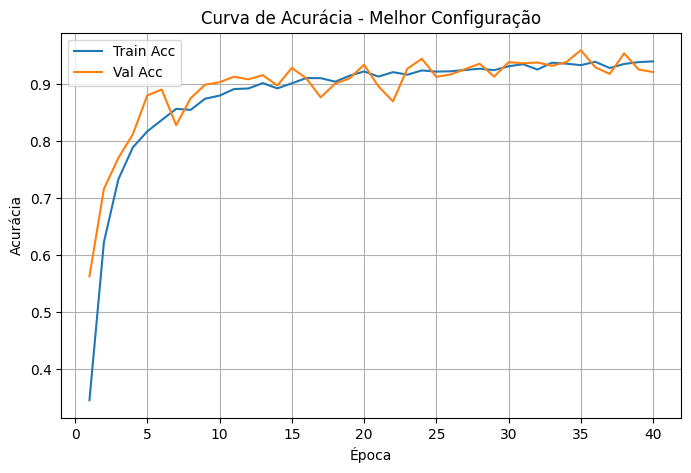

Arquivos salvos em: /content/resultados_mlp_optuna
 - Métricas por época: ./resultados_mlp_optuna/test_run_todas_metricas_por_epoca.csv
 - Resumo dos trials:  ./resultados_mlp_optuna/test_run_resumo_trials.csv
 - Melhor modelo:      ./resultados_mlp_optuna/test_run_best_model_state_dict.pt


In [19]:
# ===== Célula 8: Visualizações e caminhos dos arquivos =====
plt.figure(figsize=(8,5))
plt.plot(best_hist_df["epoch"], best_hist_df["train_loss"], label="Train Loss")
plt.plot(best_hist_df["epoch"], best_hist_df["val_loss"],   label="Val Loss")
plt.title("Curva de Loss - Melhor Configuração")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(best_hist_df["epoch"], best_hist_df["train_acc"], label="Train Acc")
plt.plot(best_hist_df["epoch"], best_hist_df["val_acc"],   label="Val Acc")
plt.title("Curva de Acurácia - Melhor Configuração")
plt.xlabel("Época"); plt.ylabel("Acurácia"); plt.grid(True); plt.legend()
plt.show()

# Atualiza a impressão dos caminhos dos arquivos para refletir o prefixo
# Para fazer isso de forma mais flexível, vamos redefinir os caminhos aqui
output_prefix = "test_run_" # Certifique-se que este prefixo corresponde ao usado em run_hparam_search
OUT_DIR = "./resultados_mlp_optuna" # Mantenha a pasta base

metrics_csv_path = os.path.join(OUT_DIR, f"{output_prefix}todas_metricas_por_epoca.csv")
trials_csv_path  = os.path.join(OUT_DIR, f"{output_prefix}resumo_trials.csv")
best_model_path  = os.path.join(OUT_DIR, f"{output_prefix}best_model_state_dict.pt")


print("Arquivos salvos em:", os.path.abspath(OUT_DIR))
print(" - Métricas por época:", metrics_csv_path)
print(" - Resumo dos trials: ", trials_csv_path)
print(" - Melhor modelo:     ", best_model_path)